# Day 22: Mode Maze

## Part 1

The two function `geoidx` and `erosion` implement a level of cross-recursion that can become very deep, better implement some memoization!

In [1]:
import numpy as np
from collections import defaultdict

G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
C = defaultdict(lambda: -1)

def geoidx(x,y,depth,xt=10,yt=10):
    if G[(x,y)]!= -1:
        return G[(x,y)]
    g = -1
    if x==xt and y==yt:
        g = 0
        G[(x,y)] = g
        return g
    if y==0:
        g = x*16807
        G[(x,y)] = g
        return g
    if x==0:
        g = y*48271
        G[(x,y)] = g
        return g
    else:
        g = erosion(x-1,y,depth,xt,yt)*erosion(x,y-1,depth,xt,yt)
        G[(x,y)] = g
        return g

def erosion(x,y,depth,xt=10,yt=10):
    if E[(x,y)]!= -1:
        return E[(x,y)] 
    e = ( geoidx(x,y,depth,xt,yt) + depth )%20183
    E[(x,y)] = e
    return e

def cavetype(x,y,depth=510,xt=10,yt=10):
    if C[(x,y)]!=-1:
        return C[(x,y)]
    c = erosion(x,y,depth,xt,yt) % 3
    C[(x,y)] = c
    return c

def exploreCave(depth=510,xt=10,yt=10):
    cave = np.zeros((yt+1,xt+1),dtype=int)
    for y in range(yt+1):
        for x in range(xt+1):
            cave[y][x] = cavetype(x,y,depth,xt,yt)
    return cave

Risk level = 114


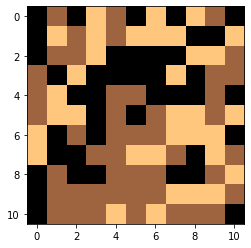

In [2]:
# Re-initialize cache dictionaries to avoid contamination between example and full input

G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
C = defaultdict(lambda: -1)
    
cave = exploreCave(depth=510,xt=10,yt=10)

import matplotlib.pyplot as plt
plt.imshow(cave,cmap="copper")
print("Risk level =",sum(sum(cave)))

In [3]:
depth = 10689
xt = 11
yt = 722

G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
C = defaultdict(lambda: -1)

cave = exploreCave(depth,xt,yt)

print("Risk level =",sum(sum(cave)))

#plt.figure(figsize=(10,100),dpi=100)
#plt.imshow(cave,cmap="copper")

Risk level = 8575


## Part 2

### Development notes

This could probably be solved with BFS tracking all possible paths of (positions on grid, equipement status) pairs, where possible next steps depend on adjacent cave values and previous equipemnt status.

On the other hand, there's no guarantee that the best path would be in the minimal rectangle needed to solve Part 1, so I should probably generate a larger cave. I can maybe avoid doing this beforehand by also caching the already-computed cave type in a `defaultdict`, and let the recursion compute and store whethevent is needed on the fly.

* Solution: adding `cavetype` function and `C` dictionary to Part 1

BFS itself is probably not enough since moving have different "cost" (e.g. time) depeding on whether I need to swicth equipement. Maybe I can introduce a priority queue sorting path by shorter time up to current position?

* Solution: using `PriorityQueue` with time as index

Ok, I can solve the example! Is this what they call a **Dijkstra's algorithm**?
To speedup things I now only save the last (position,equipment) and not the full path.

Still failing with the full input: the problem was the way I was keeping track of the `visited` position, only considering the coordinate/equipement but not the traveled time. [Got an hint on reddit](https://www.reddit.com/r/adventofcode/comments/m1u5dj/2018_day_22_any_helphint_to_debug_part_2_solution/), thanks AOC community!

* Solution: `visited` now tracks traveled time, and I only queue new position/equipement if their travel time is smaller than what was seen already. `visited` default is very large number!

In order to speed up process even more, I'm now exploring the option of replacing time in `PriorityQueue` with some heuristic also accounting for distance of current point to targe position...

* Solution: it makes a lot of sense to prioritize positions that have at the same time smaller travel time and shorter distance to target, since residual distance will result in additional travel time. Given the way travel time is defined, Manhattan distance is a good proxy

Is this what they call a **A* algorithm**?

In [4]:
def getAdiacent(s):
    x,y = s
    return [ (x+i,y+j) for i in (+1,0,-1) for j in (+1,0,-1) if x+i>=0 and y+j>=0 and i!=j and abs(i+j)==1 and (x+i,y+j)!=s  ]

#getAdiacent((0,0))
getAdiacent((1, 1))

[(2, 1), (1, 2), (1, 0), (0, 1)]

In [5]:
ROCKY  = 0 # CLIMB or TORCH : 1, 2
WET    = 1 # CLIMB or NONE  : 2, 0
NARROW = 2 # TORCH or NONE  : 1, 0

NONE  = 0
TORCH = 1
CLIMB = 2

def validEquipIfs(cavetype,equip):
    if cavetype==ROCKY and ( equip==CLIMB or equip==TORCH ):
        return True
    elif cavetype==WET and ( equip==CLIMB or equip==NONE ):
        return True
    elif cavetype==NARROW and ( equip==TORCH or equip==NONE ):
        return True
    else:
        return False

def validEquip(cavetype,equip):
    return cavetype != equip

ct = NARROW
eq = TORCH
validEquipIfs(ct,eq), validEquip(ct,eq)

(True, True)

In [6]:
# 0: 1,2
# 1: 0,2
# 2: 1,0

#def alterEquip(equip):
#    eqList = [ NONE, TORCH, CLIMB ]
#    eqList.pop( eqList.index(equip) )
#    return eqList

def alterEquip(equip):
    if equip==NONE:
        return [ TORCH, CLIMB ]
    elif equip==TORCH:
        return [ NONE, CLIMB ]
    elif equip==CLIMB:
        return [ NONE, TORCH ]

alterEquip(CLIMB)

[0, 1]

In [27]:
from queue import PriorityQueue
from copy import deepcopy

def heuristic(t,p,e):
    xp,yp = p
    xe,ye = e
    # Manhattan distance: if no equipement change, this would be the time need to go from p to e ...
    d = abs(xe-ye)+abs(ye-yp)
    # ... so penalize each point by this additional time: farer point at same t will go down in priority
    return t+d

def getShortedPath(depth = 510, xt = 10, yt = 10, heu=0):
    
    start = (0,0)
    end = (xt,yt)

    s = (start,TORCH)
    e = (end,TORCH)
    
    # keep track of time of last visit to each position 
    # update queue with position/equipement only if new passage 
    # happens at earlier time
    visited = defaultdict(lambda: 1e32)
    visited[(s,0)] = 0
    
    q = PriorityQueue()
    q.put((0,(s,0)))
    
    steps = 0
    
    while True:
        
        h,pet = q.get()
        pe,t = pet
        
        if pe==e:
            print("Reached target at",end,"in t =", t, end=". ")
            print("Steps =",steps)
            return
        
        p,eq = pe        
        xp,yp = p    
        ctp = cavetype(xp,yp,depth,xt,yt)
        
        for a in getAdiacent(p):

            xa,ya = a
            cta = cavetype(xa,ya,depth,xt,yt)

            # current equipement is valid for next step
            if validEquip(cta,eq): 
                ns = (a,eq)
                ts = t+1
                # queue this step only if happens at earlier time that seen before
                if ts < visited[ns]:
                    visited[ns] = ts
                    h = ts
                    if heu!=0:
                        h = heuristic(ts,a,end)
                    q.put((h,(ns,ts)))
                
            # also try to change equipement staying on same place, 
            # since it might lead to better path later despite loss in time now 
            for alteq in alterEquip(eq):
                if validEquip(ctp,alteq):
                    ns = (p,alteq)
                    ts = t+7
                    # queue this step only if happens at earlier time that seen before
                    if ts < visited[ns]:
                        visited[ns] = ts
                        h = ts
                        if heu!=0:
                            h = heuristic(ts,p,end)
                        q.put((h,(ns,ts)))

        steps += 1

Reached target at (10, 10) in t = 45. Steps = 596


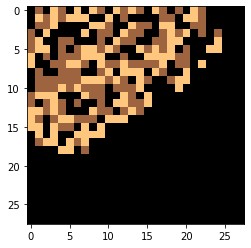

In [35]:
# Example: fastest way to reach the target: 45 minutes. 

G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
C = defaultdict(lambda: -1)

getShortedPath(depth=510,xt=10,yt=10)

cave = np.zeros((28,28),dtype=int)
for x,y in C.keys():
    cave[y][x] = C[(x,y)]
    
s = plt.imshow(cave,cmap="copper")

Reached target at (10, 10) in t = 45. Steps = 436


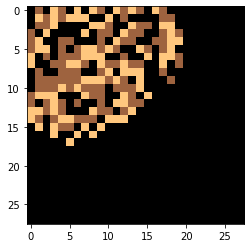

In [36]:
G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
C = defaultdict(lambda: -1)

getShortedPath(depth=510,xt=10,yt=10,heu=1)

cave = np.zeros((28,28),dtype=int)
for x,y in C.keys():
    cave[y][x] = C[(x,y)]
    
s = plt.imshow(cave,cmap="copper")

Reached target at (11, 722) in t = 999. Steps = 993738


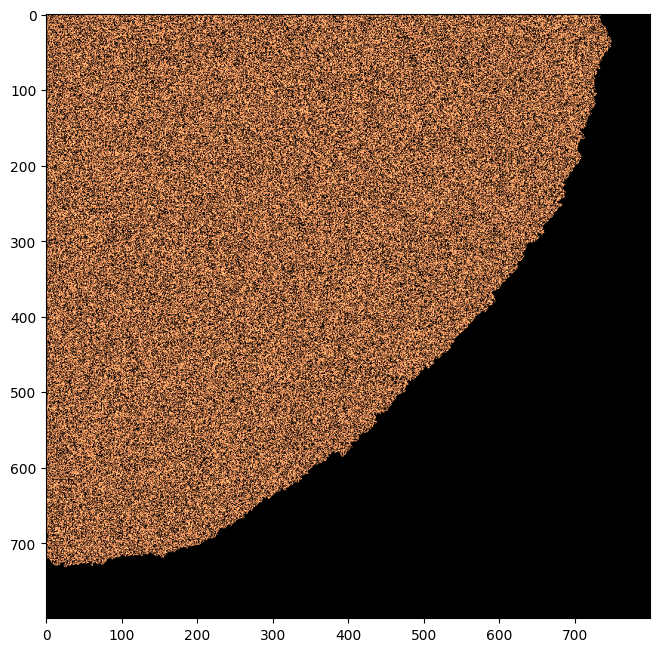

In [37]:
G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
C = defaultdict(lambda: -1)

getShortedPath(depth=10689,xt=11,yt=722)

cave = np.zeros((800,800),dtype=int)
for x,y in C.keys():
    cave[y][x] = C[(x,y)]

plt.figure(figsize=(8,8),dpi=100)
s = plt.imshow(cave,cmap="copper")

Reached target at (11, 722) in t = 999. Steps = 407984


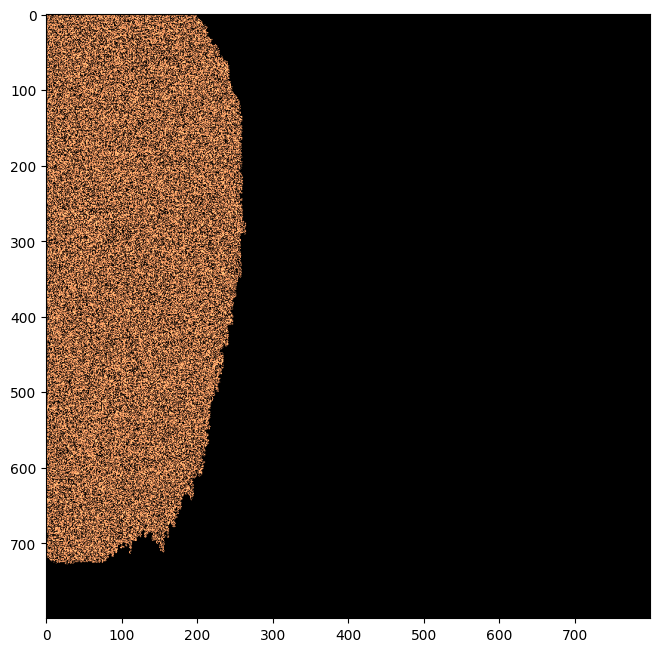

In [38]:
G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
C = defaultdict(lambda: -1)

getShortedPath(depth=10689,xt=11,yt=722,heu=1)

cave = np.zeros((800,800),dtype=int)
for x,y in C.keys():
    cave[y][x] = C[(x,y)]
    
plt.figure(figsize=(8,8),dpi=100)
s = plt.imshow(cave,cmap="copper")